# Week 3: Fitting

**Please indicate at the top of your assignment whether or not you used any AI tools, such as MS Copilot. If you did use one of these tools, please provide a very brief explanation alongside each answer for how you confirmed the correctness of your solution.**

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares

np.seterr(over='raise')


def Req_func(Phisum, Rtot, L0, KxStar, f, Ka):
    """ Mass balance. Transformation to account for bounds. """
    Req = Rtot / (1.0 + L0 * f * Ka * (1 + Phisum) ** (f - 1))
    return Phisum - Ka * KxStar * Req


def StoneMod(Rtot: float, Kd: float, v, Kx: float, L0: np.ndarray):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    assert L0.shape == v.shape

    if Rtot <= 0.0:
        raise RuntimeError("You input a negative amount of receptor.")
    
    if Kx <= 0.0:
        raise RuntimeError("You input a negative Kx.")

    if np.amin(L0) <= 0.0:
        raise RuntimeError("You input a negative L0.")

    Ka = 1.0 / Kd
    KxStar = Kx / Ka

    ## Solve Req by calling least_squares
    lsq = least_squares(Req_func, np.ones_like(L0), jac="cs",
                        max_nfev=5000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        args=(Rtot, L0, KxStar, v, Ka))

    if lsq['success'] is False:
        print(lsq)
        raise RuntimeError("Failure in solving for Req. If you see this message contact Dr. Meyer.")

    Phisum = lsq.x

    # Calculate L, according to equation 7
    Lbound = L0 / KxStar * ((1 + Phisum) ** v - 1)

    # Calculate Rmulti from equation 5
    Rmulti = L0 / KxStar * v * Phisum * ((1 + Phisum) ** (v - 1) - 1)

    # Calculate Rbound
    Rbnd = L0 / KxStar * v * Phisum * (1 + Phisum) ** (v - 1)

    return Lbound, Rbnd, Rmulti

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

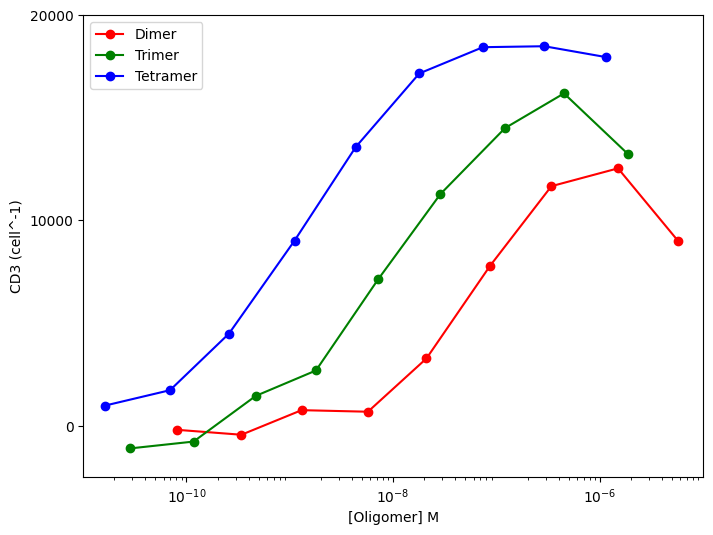

In [2]:
# Note that Xs are the concentrations from the experiment
# Vs are the complex valencies
# Ys are the measurements of response
# Each of these vectors is the same length, with each position describing an experimental measurement

def plot_valency_data(Xs_in, Ys_in, Vs_in, format='o-'):
    """If you pass in your real or simulated data, this will plot it for you."""
    colors = ['r', 'g', 'b']

    for valency in range(3):
        plt.semilogx(Xs_in[Vs_in == valency + 2], 
                     Ys_in[Vs_in == valency + 2],
                     colors[valency] + format)

    plt.xlim([1E-11, 1E-5])
    plt.xticks([1E-10, 1E-8, 1E-6])
    plt.xlabel('[Oligomer] M')

# Answer
def setup_plot():
    plt.ylim([-2500, 20000])
    plt.yticks([0, 10000, 20000])
    plt.xlim([1E-11, 1E-5])
    plt.xticks([1E-10, 1E-8, 1E-6])
    plt.ylabel('CD3 (cell^-1)')
    plt.xlabel('[Oligomer] M')

plt.figure(figsize=(8, 6))
plot_valency_data(Xs, Ys, Vs)
setup_plot()
plt.legend(['Dimer', 'Trimer', 'Tetramer'])
plt.show()

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

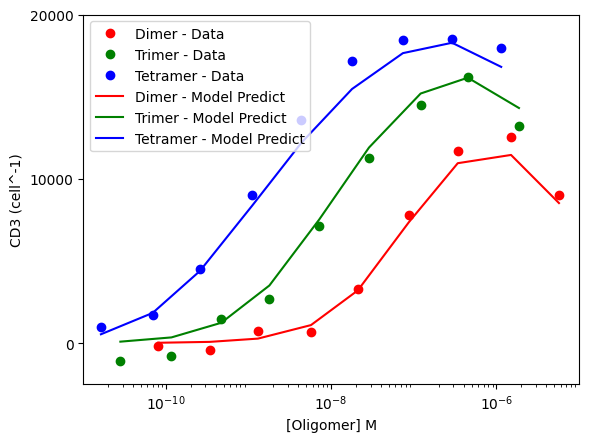

In [3]:
# Here is a scaling function
# Note that the unknown parameters are passed in as an array
# This will make working with least_squares() easier later
# parameters = [scale, Kd (M), Kx (cell)]
def scale_StoneMod(parameters, Vs, Xs):
    Rtot = 24000.0 # cell^-1
    Lbound, Rbnd, Rmulti = StoneMod(Rtot, parameters[1], Vs, parameters[2], Xs)
    return parameters[0] * Rmulti

# Answer
Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4
scale = 1

scaled_model = scale_StoneMod([scale, Kd, Kx], Vs, Xs)

plot_valency_data(Xs, Ys, Vs, format="o")
plot_valency_data(Xs, scaled_model, Vs, format="-")
setup_plot()
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Model Predict', 'Trimer - Model Predict',
            'Tetramer - Model Predict']);

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

You should use information from the paper to start at a good guess for the parameter values.

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.137e+02 -5.099e+02 ... -3.079e+02  6.721e+02]
           x: [ 1.028e+00  1.703e-06  3.147e-04]
        cost: 6858021.330794917
         jac: [[-1.722e+01  1.029e+07 -5.617e+04]
               [-7.190e+01  4.275e+07 -2.335e+05]
               ...
               [-1.828e+04 -1.247e+08 -1.067e+07]
               [-1.681e+04 -1.206e+09 -1.202e+07]]
        grad: [-2.520e-01  1.890e+07 -1.638e+05]
  optimality: 18901516.128173828
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 7
        njev: 4


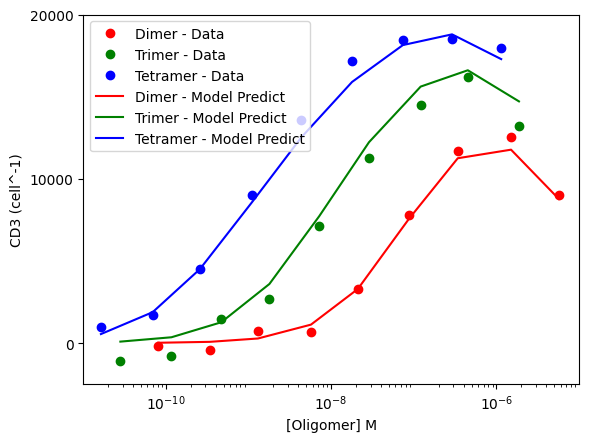

In [4]:
# You will need a function that returns the residuals:
def residuals(parameters, Vs_in, Xs_in, Ys_in):
    return Ys_in - scale_StoneMod(parameters, Vs_in, Xs_in)

# Note that the data (Xs, Ys) are not unknowns, so they should be passed in using the args argument of least_squares

# With this function, your least squares call should look something like this:
# lsq_solution = least_squares(residuals, params_guess, args=(Vs, Xs, Ys))

# Answer
scale_guess = 1
params_guess = [scale_guess, Kd, Kx]
lsq_params = least_squares(residuals, params_guess, args=(Vs, Xs, Ys), ftol=1e-12)
best_params = lsq_params.x.copy()

print(lsq_params)

scaled_model = scale_StoneMod(lsq_params.x, Vs, Xs)

plot_valency_data(Xs, Ys, Vs, format="o")
plot_valency_data(Xs, scaled_model, Vs, format="-")
setup_plot()
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Model Predict', 'Trimer - Model Predict',
            'Tetramer - Model Predict']);

#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

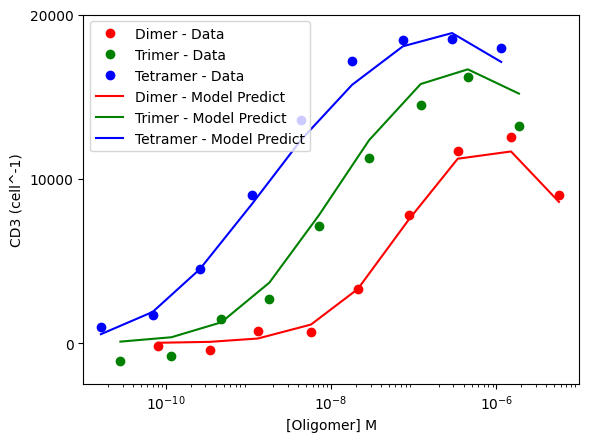

In [5]:
# scikit-learn provides a great interface for getting indices that help you split the data
from sklearn.model_selection import LeaveOneOut

# for train_idx, test_idx in LeaveOneOut().split(Vs):
#     Vs_training = Vs[train_idx]
#     Vs_testing = Vs[test_idx]

    # Xs_training...

# Answer

cv_pred = np.empty_like(Ys)

for train_index, test_index in LeaveOneOut().split(Xs):
    X_train, X_test = Xs[train_index], Xs[test_index]
    Y_train, _ = Ys[train_index], Ys[test_index]
    V_train, V_test = Vs[train_index], Vs[test_index]
    
    lsq_params = least_squares(residuals, best_params, args=(V_train, X_train, Y_train), ftol=1e-12)

    cv_pred[test_index] = scale_StoneMod(lsq_params.x, V_test, X_test)
    
plot_valency_data(Xs, Ys, Vs, format="o")
plot_valency_data(Xs, cv_pred, Vs, format="-")
setup_plot()
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Model Predict', 'Trimer - Model Predict',
            'Tetramer - Model Predict']);

# A plot with measured on one axis, and predicted on the other, is also great.

#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

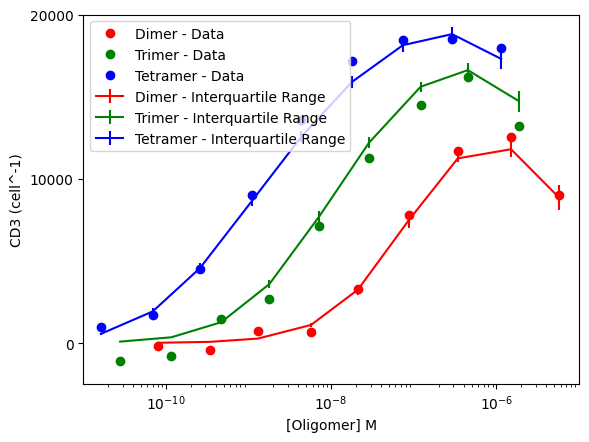

In [6]:
# sklearn has a very useful resample function
from sklearn.utils import resample

# For example, to resample the data, you can do this:
# resamp = resample(range(Vs.size))
# Vs_resampled = Vs[resamp]
# Xs_resampled = Xs[resamp]
# Ys_resampled = Ys[resamp]

# Answer

boot_pred = np.zeros((100, Xs.size))

for boot_index in range(boot_pred.shape[0]):
    X_resamp, Y_resamp, V_resamp = resample(Xs, Ys, Vs, replace=True)
    
    lsq_params = least_squares(residuals, params_guess, args=(V_resamp, X_resamp, Y_resamp), ftol=1e-12)

    boot_pred[boot_index, :] = scale_StoneMod(lsq_params.x, Vs, Xs)


quants = np.quantile(boot_pred, (0.25, 0.5, 0.75), axis=0)
iqr = quants[2, :] - quants[0, :]

plot_valency_data(Xs, Ys, Vs, format="o")
setup_plot()

colors = ["r", "g", "b"]

for i in range(3):
    idx = (9*i, 9*(i+1))
    plt.errorbar(Xs[idx[0]:idx[1]], quants[1, idx[0]:idx[1]], yerr=iqr[idx[0]:idx[1]], color=colors[i])

plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Interquartile Range', 'Trimer - Interquartile Range',
            'Tetramer - Interquartile Range']);

#### (6) Use bootstrap sampling to show the uncertainty in the model prediction for the amount of `Lbnd` for 1 nM of MHC-peptide complex of valency 4. Ensure that you show correct units.

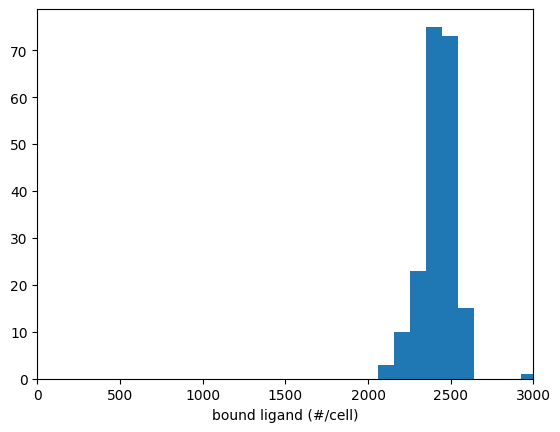

In [7]:
# Answer.

Lb_pred = np.zeros((200, ))

for boot_index in range(Lb_pred.shape[0]):
    X_resamp, Y_resamp, V_resamp = resample(Xs, Ys, Vs, replace=True)

    lsq_params = least_squares(residuals, params_guess, args=(V_resamp, X_resamp, Y_resamp), ftol=1e-12)

    Rtot = 24000.0 # cell^-1
    Lbnd, _, _ = StoneMod(Rtot, lsq_params.x[1], np.array([4.0]), lsq_params.x[2], np.array([1.0e-9]))

    Lb_pred[boot_index] = Lbnd[0]


plt.hist(Lb_pred);
plt.xlabel("bound ligand (#/cell)");
plt.xlim(0, 3000);

#### (6) _Generally_, how would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

Answer.

With fewer data points, I would expect the cross-validation fit to become worse, as the model will have less information on which to base predictions.

As for the bootstrapping results, I'd expect larger variance for the predictions of each data point. The model will be worse because it has fewer data points, and the influence of each data point will be greater, so it will matter more whether it has increased or decreased influence on the model fit after resampling.

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down relative to its optimum by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter affects the error the most? Which one the least?

You should get a plot that roughly looks like a "U" for each parameter. Use a log-log plot to show the variation the best (`plt.loglog`).

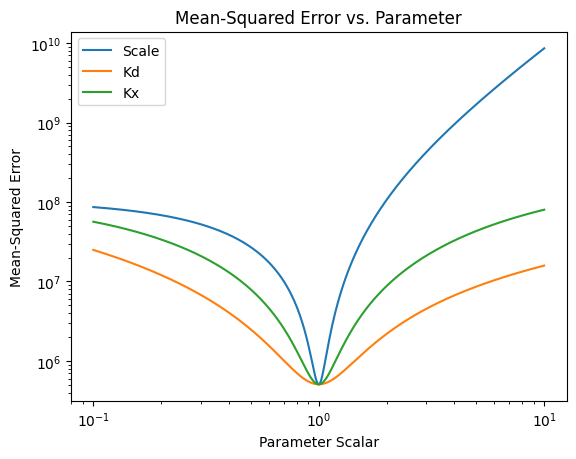

In [8]:
# Answer

from sklearn.metrics import mean_squared_error

param_mods = np.logspace(-1, 1, 501)

mse_scale = []
mse_kd = []
mse_kx = []

for param_mod in param_mods:
    params = best_params.copy()
    params[0] *= param_mod
    mod_scale = scale_StoneMod(params, Vs, Xs)
    mse_scale.append(mean_squared_error(Ys, mod_scale))
    
    params = best_params.copy()
    params[1] *= param_mod
    mod_kd = scale_StoneMod(params, Vs, Xs)
    mse_kd.append(mean_squared_error(Ys, mod_kd))
    
    params = best_params.copy()
    params[2] *= param_mod
    mod_kx = scale_StoneMod(params, Vs, Xs)
    mse_kx.append(mean_squared_error(Ys, mod_kx))


plt.semilogx(param_mods, mse_scale)
plt.semilogx(param_mods, mse_kd)
plt.semilogx(param_mods, mse_kx)
plt.ylabel('Mean-Squared Error')
plt.xlabel('Parameter Scalar')
plt.xticks([.1, 1, 10])
plt.title('Mean-Squared Error vs. Parameter')
plt.legend(['Scale', 'Kd', 'Kx'])
plt.yscale('log')